In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
cuda = torch.cuda.is_available()

In [4]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [6]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 10),
                 latent_dim=2, n_samples=10,
                 fc_size=1024, num_layers=2):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_shape[-1], fc_size))
        encoder_layers.append(nn.ReLU())
        for i in range(1,num_layers):
            encoder_layers.append(nn.Linear(fc_size//2**(i-1), fc_size//2**i))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
            
        self.fc_mu = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        self.fc_logvar = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, fc_size//2**(num_layers-1)))
        decoder_layers.append(nn.ReLU())
        
        for i in range(num_layers-1):
            decoder_layers.append(nn.Linear(fc_size//2**(num_layers-1-i), fc_size//2**(num_layers-i-2)))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(fc_size, 2*input_shape[1]))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        dec_out = self.decoder(z)
        if len(dec_out.shape) == 3:
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs

    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [7]:
def loss_function(log_probs, x, mu, logvar, n_samples=10):
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        x = x.view(-1, 1, x.shape[1]).clone()
        x = x.repeat(1, n_samples, 1)
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0])

    elbo = LL - KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [8]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [10]:
from matplotlib.patches import Ellipse

colors = ['red', 'green', 'blue', 'orange', 'pink']
def plot_point_with_std(mu, std, title='Latent variable distributions'):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, aspect='equal')

    e = Ellipse([0,0], 6, 6)
    e.set_alpha(0.75)
    e.set_facecolor('white')
    e.set_edgecolor('black')
    ax.add_artist(e)

    
    for i in range(len(mu)):
        e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
        e.set_alpha(0.25)
        e.set_facecolor('gray')
        ax.add_artist(e)

        plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                 color=colors[i], alpha=0.8)
    plt.grid()
    plt.title(tile, fontsize=16)
    plt.xlim((-4,4))
    plt.ylim((-4,4))

In [11]:
def plot_learning_history_with_pgs(logs, pgs,
                                   title='online training',
                                   filename=None):
    
    ll_log, kld_log = logs[0], logs[1]
    
    plt.figure(figsize=(15, 5))
    linewidth = 4
    
    plt.subplot(1, 3, 1)
    plt.plot(ll_log)
    plt.title('LL ({})'.format(title), fontsize=15)
    plt.title('Log-Likelihood ({})'.format(title), fontsize=15)
    plt.ylabel('LL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(kld_log)
    plt.title('KL-divergence ({})'.format(title), fontsize=15)
    plt.ylabel('KL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    plt.subplot(1, 3, 3)
    plt.plot(pgs)
    plt.axhline(y=0, color='r', linewidth=5)
    plt.ylim(-1, 5)
    plt.title('Prediction gains ({})'.format(title), fontsize=15)
    plt.ylabel('PG', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()

In [12]:
def plot_learning_history(logs, mu=None, std=None, title='batch training', filename=None):
    
    ll_log, kld_log = logs[0], logs[1]
    n_plots = 2 if mu is None else 3
        
    plt.figure(figsize=(5*n_plots, 5))
    linewidth = 4

    plt.subplot(1, n_plots, 1)
    plt.plot(ll_log)
    plt.title('Log-Likelihood ({})'.format(title), fontsize=15)
    plt.ylabel('LL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    plt.subplot(1, n_plots, 2)
    plt.plot(kld_log)
    plt.title('KL-divergence ({})'.format(title), fontsize=15)
    plt.ylabel('KL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    """ 
    plt.subplot(1, n_plots, 3)
    plt.plot(pg_log)
    plt.title('Prediction gain ({})'.format(title), fontsize=15)
    plt.ylabel('PG', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.axhline(y=0, color='r', linewidth=1)
    plt.grid()
    """
    
    if mu is not None and std is not None:
        ax= plt.subplot(1, n_plots, n_plots)
        #ax = fig.add_subplot(111, aspect='equal')

        e = Ellipse([0,0], 6, 6)
        e.set_alpha(0.75)
        e.set_facecolor('white')
        e.set_edgecolor('black')
        ax.add_artist(e)


        for i in range(len(mu)):
            e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
            e.set_alpha(0.25)
            e.set_facecolor('gray')
            ax.add_artist(e)

            plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                     color=colors[i], alpha=0.8, label='class {}'.format(int(i+1)))
        plt.legend(loc='lower right')
        plt.grid()
        plt.title('Latent variable distributions', fontsize=16)
        plt.xlim((-4,4))
        plt.ylim((-4,4))    
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()

In [13]:
dim = 50
num_classes = 5

In [14]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

In [9]:
def get_obj_log_prob(model, obj, treat_as_var=False, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar, model.n_samples)

    if not treat_as_var:
        log_probs = log_probs.data.numpy()[0].mean(axis=0)
    else:
        log_probs = log_probs[0].mean(dim=0)

    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [54]:
def copy_models(model, tmp_model):
    for m_from, m_to in zip(model.modules(), tmp_model.modules()):
        if isinstance(m_to, nn.Linear):
            m_to.weight.data = m_from.weight.data.clone()
            if m_to.bias is not None:
                m_to.bias.data = m_from.bias.data.clone()

In [88]:
import copy
from torch import autograd

def maml_optimization_step(obj, model, tmp_model, optimizer, tmp_optimizer, alpha=0.1):
    copy_models(model, tmp_model)
    data = convert_to_var(obj[np.newaxis,:])
    
    # perform optimization step in order to get \theta_1
    log_prob_before = get_obj_log_prob(tmp_model, obj, treat_as_var=True)

    _, log_probs, mu, logvar = tmp_model(data)
    loss, _, _ = loss_function(log_probs, data, mu, logvar, tmp_model.n_samples)
    tmp_optimizer.zero_grad()
    loss.backward()
    tmp_optimizer.step()
    
    log_prob_after = get_obj_log_prob(tmp_model, obj, treat_as_var=True)

    pg = log_prob_after - log_prob_before
    ######################################################
    
    # count combined loss
    _, log_probs, mu, logvar = tmp_model(data)
    loss, _, _ = loss_function(log_probs, data, mu, logvar, tmp_model.n_samples)
    print('inner pg', pg.data.numpy()[0])
    combined_loss = loss - pg
    ######################################################
    
    # get gradients of combined loss
    grads = autograd.grad(combined_loss, tmp_model.parameters(), create_graph=True)

    #get dummy loss on theta_0 params
    _, log_probs, mu, logvar = model(data)
    dummy_loss, _, _ = loss_function(log_probs, data, mu, logvar, model.n_samples)

    #change gradients in dummy_loss
    hooks = []
    for i, v in enumerate(model.parameters()):
        def closure():
            ii = i
            return lambda grad: grads[ii]
        hooks.append(v.register_hook(closure()))

    #final optimization
    optimizer.zero_grad()
    dummy_loss.backward()
    optimizer.step()

    #remove hooks
    for h in hooks:
        h.remove()


In [89]:
def run(run_iter=None,
       fc_size=1024, num_layers=2, n_samples=25,
       lr=0.0001, momentum=0.9, img_name=None):
    
    np.random.seed(11)

    model = VAE(latent_dim=2, input_shape=(-1, dim),
                n_samples=n_samples, fc_size=fc_size, num_layers=num_layers)
    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    
    tmp_model = VAE(latent_dim=2, input_shape=(-1, dim),
                    n_samples=n_samples, fc_size=fc_size, num_layers=num_layers)
    tmp_optimizer = optim.RMSprop(tmp_model.parameters(), lr=lr, momentum=momentum)

    pgs = []
    train_logs = [[] for _ in range(2)]
    num_steps = 100#int(1e3)
    
    for t in range(num_steps):
        cur_class = np.random.randint(low=0, high=5)            
        obj = get_one_hot_object(cur_class, dim, num_classes)
        data = convert_to_var(obj[np.newaxis,:])
        log_prob_before, loss, ll, kld = get_obj_log_prob(model, obj, return_loss=True)
        train_logs[0].append(ll.data.numpy()[0])
        train_logs[1].append(kld.data.numpy()[0])

        maml_optimization_step(obj, model, tmp_model, optimizer, tmp_optimizer)
        
        log_prob_after = get_obj_log_prob(model, obj, return_loss=False)

        pg = log_prob_after - log_prob_before
        print('outer pg', pg)
        print()
        pgs.append(pg)

                
    if img_name is not None:
        plot_learning_history_with_pgs(train_logs, pgs, filename=img_name)
    else:
        plot_learning_history_with_pgs(train_logs, pgs)
    
    pgs = np.array(pgs)
    pct = (pgs < 0).mean()
    
    lls = np.array(train_logs[0])
    mean_last_ll = lls[-10:].mean()
    
    return mean_last_ll, pct

inner pg 10.42429
outer pg 11.161356

inner pg 6.609585
outer pg 4.5761223

inner pg 7.0070143
outer pg 8.984522

inner pg 0.55804825
outer pg -5.1819954

inner pg 2.2119951
outer pg 1.470004

inner pg 17.473818
outer pg 7.1721573

inner pg 70.40105
outer pg 55.8332

inner pg 14.593587
outer pg 9.100883

inner pg 6.103771
outer pg 3.002983

inner pg 38.17794
outer pg 7.191284

inner pg 41.92775
outer pg 9.91766

inner pg 43.47665
outer pg 6.7704773

inner pg -32.51038
outer pg 2.4190307

inner pg 14.62648
outer pg -34.3604

inner pg -9.363226
outer pg 10.629462

inner pg 24.69254
outer pg -3.985855

inner pg 30.611008
outer pg -13.880363

inner pg 46.775307
outer pg 9.522209

inner pg 246.98697
outer pg 90.91362

inner pg 13.447546
outer pg 10.901953

inner pg 1.1340382
outer pg 2.2027962

inner pg 230.17337
outer pg 131.6933

inner pg -0.91858673
outer pg 29.359982

inner pg 51.28752
outer pg 33.67497

inner pg 7.8139496
outer pg 4.5832863

inner pg -9.072387
outer pg -1.9554024

inne

(-2.4341626, 0.25)

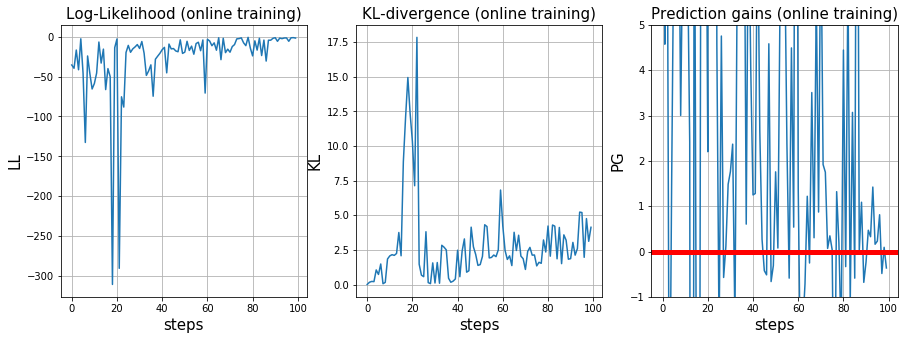

In [90]:
%%time
run(run_iter=None,
    fc_size=1024, num_layers=2, n_samples=25)